In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Loading and Visualizing the Data.

In [12]:
year_3_df = pd.read_csv('../data/DGS3.csv', date_parser=['DATE'])
year_5_df = pd.read_csv('../data/DGS5.csv', date_parser=['DATE'])

df = pd.merge(year_3_df, year_5_df)

In [13]:
# Converts object to 

def convert_df(series):
    return pd.to_numeric(series, errors='coerce')

In [14]:
df['DGS3'] = convert_df(df['DGS3'])
df['DGS5'] = convert_df(df['DGS5'])
df['DATE'] = pd.to_datetime(df['DATE'])

df.set_index('DATE', inplace=True)

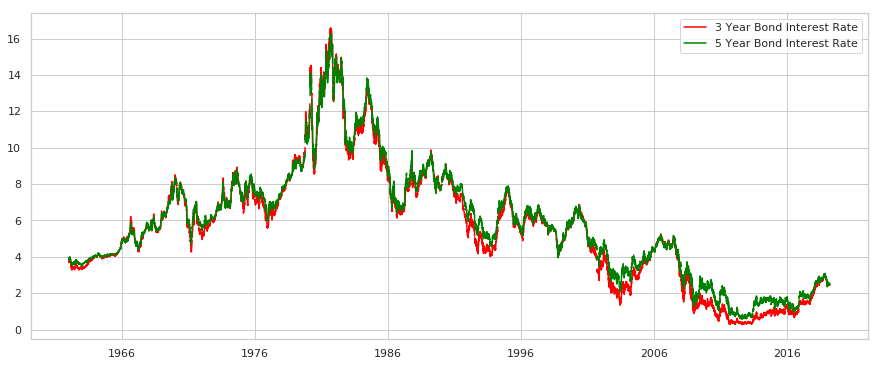

In [15]:
sns.set(style="whitegrid")
plt.figure(figsize=(15, 6))

plt.plot(df['DGS3'], color='red', label='3 Year Bond Interest Rate')
plt.plot(df['DGS5'], color='green', label='5 Year Bond Interest Rate')
plt.legend()

# Calculating the interest difference

In [16]:
df['DIFF'] = df['DGS5'] - df['DGS3']

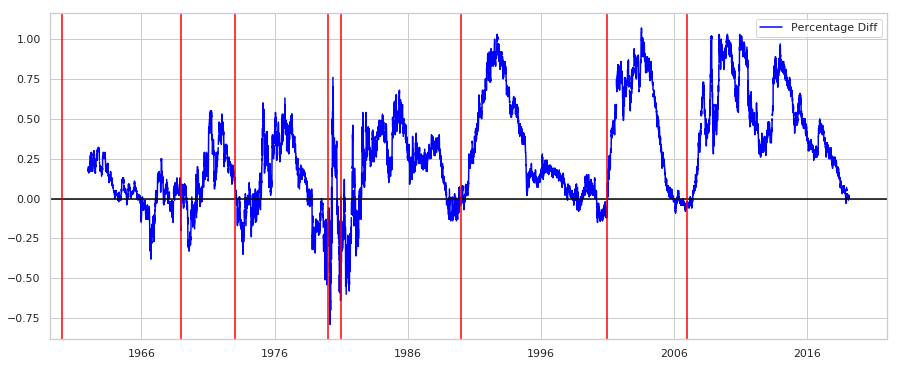

In [17]:
import datetime as dt

sns.set(style="whitegrid")
plt.figure(figsize=(15, 6))
plt.plot(df['DIFF'], color='blue', label='Percentage Diff')
plt.legend()

plt.axhline(0, color='black')

years = [1960, 1969, 1973, 1980, 1981, 1990, 2001, 2007]

for year in years:
    plt.axvline(dt.datetime(year, 1, 1), color='red')


In [18]:
df.head()

,DGS3,DGS5,DIFF
DATE,,,
1962-01-02,3.70,3.88,0.18
1962-01-03,3.70,3.87,0.17
1962-01-04,3.69,3.86,0.17
1962-01-05,3.71,3.89,0.18
1962-01-08,3.71,3.91,0.20


In [19]:
pd.DataFrame(df['DIFF']).reset_index().head()

,DATE,DIFF
0,1962-01-02,0.18
1,1962-01-03,0.17
2,1962-01-04,0.17
3,1962-01-05,0.18
4,1962-01-08,0.20


In [20]:
pd.DataFrame(df['DIFF']).reset_index().to_csv('../data/diff_df.csv', index=False)

# Forecasting Methods

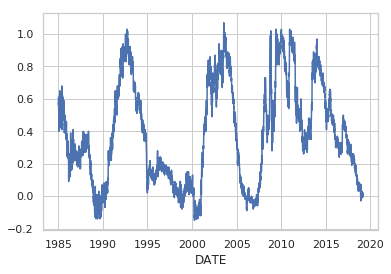

In [10]:
df = df.fillna(method='ffill')
df[df.index > '1985'].DIFF.plot()
df = df[df.index > '1985']

In [11]:
Train = df[:'2018']
valid = df['2018':]

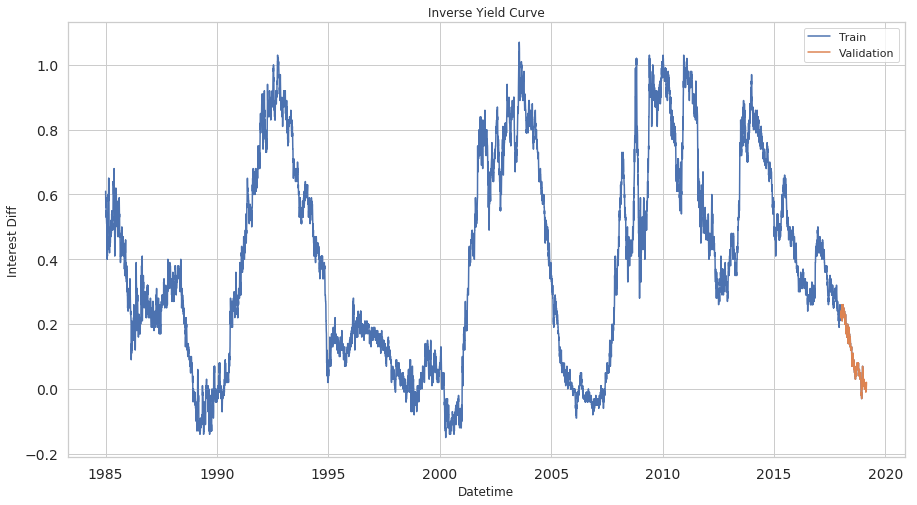

In [12]:
Train.DIFF.plot(figsize=(15, 8), title='Inverse Yield Curve', fontsize=14, label='Train')
valid.DIFF.plot(figsize=(15, 8), title='Inverse Yield Curve', fontsize=14, label='Validation')
plt.xlabel('Datetime')
plt.ylabel('Interest Diff')
plt.legend(loc = 'best')

# Exponential Smoothing

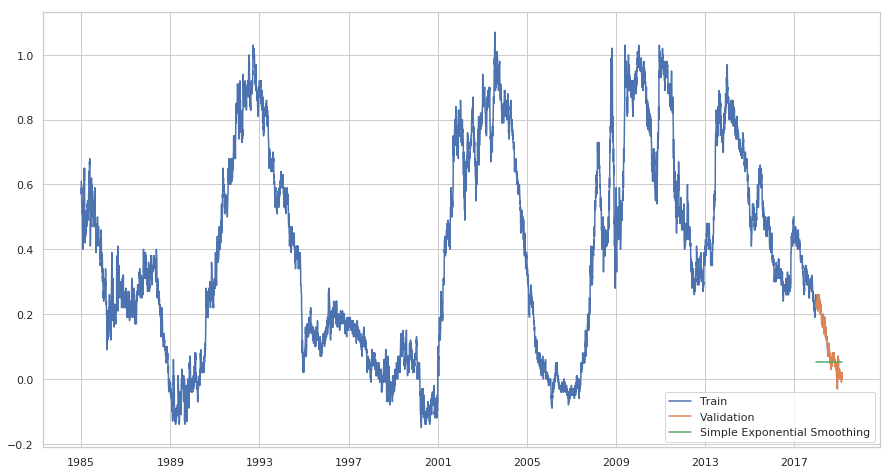

In [15]:
from statsmodels.tsa.api import ExponentialSmoothing,SimpleExpSmoothing, Holt

y_hat = valid.copy()
fit2 = SimpleExpSmoothing(np.asarray(Train['DIFF'])).fit(smoothing_level = 0.6,optimized = False)
y_hat['SES'] = fit2.forecast(len(valid))
plt.figure(figsize =(15,8))
plt.plot(Train['DIFF'], label = 'Train')
plt.plot(valid['DIFF'], label = 'Validation')
plt.plot(y_hat['SES'], label = 'Simple Exponential Smoothing')
plt.legend(loc = 'best')

# Approaches

- [x] Prophet : We could potentially mix the upper and lower trends by ratio and get a proper forecast of the curve

In [16]:
from fbprophet import Prophet

In [17]:
df_prophet = pd.DataFrame(df.DIFF)
df_prophet.reset_index(inplace=True)
df_prophet.columns = ['ds', 'y']

In [18]:
df_prophet.head()

,ds,y
0,1985-01-02,0.61
1,1985-01-03,0.58
2,1985-01-04,0.57
3,1985-01-07,0.59
4,1985-01-08,0.56


In [18]:
df_prophet.head()

model = Prophet(changepoint_prior_scale=1, changepoint_range=1)
model.fit(df_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


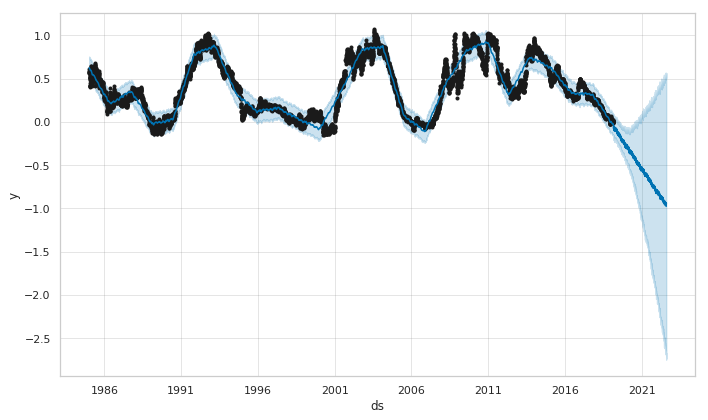

In [19]:
# Future predictions
future = model.make_future_dataframe(periods=1260, freq='D')
forecast = model.predict(future)
fig = model.plot(forecast)

In [20]:
future.head()

,ds
0,1985-01-02
1,1985-01-03
2,1985-01-04
3,1985-01-07
4,1985-01-08


In [21]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
10167,2022-08-07,-0.973353,-2.697893,0.517490
10168,2022-08-08,-0.941158,-2.667497,0.554955
10169,2022-08-09,-0.942352,-2.735241,0.565332
10170,2022-08-10,-0.943523,-2.714775,0.548941
10171,2022-08-11,-0.944183,-2.714509,0.541218


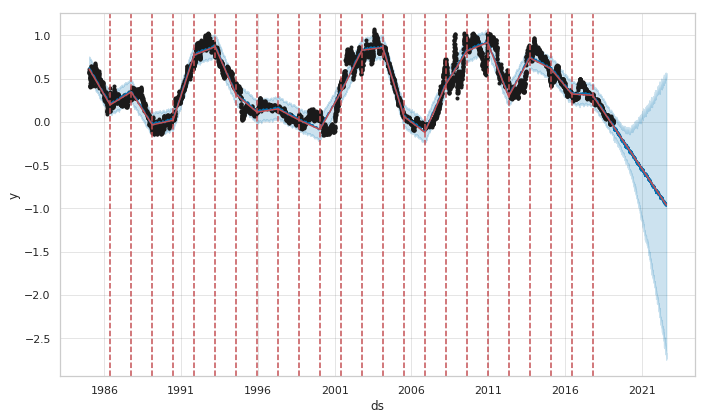

In [22]:
from fbprophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

In [23]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
10167,2022-08-07,-0.973353,-2.697893,0.517490
10168,2022-08-08,-0.941158,-2.667497,0.554955
10169,2022-08-09,-0.942352,-2.735241,0.565332
10170,2022-08-10,-0.943523,-2.714775,0.548941
10171,2022-08-11,-0.944183,-2.714509,0.541218


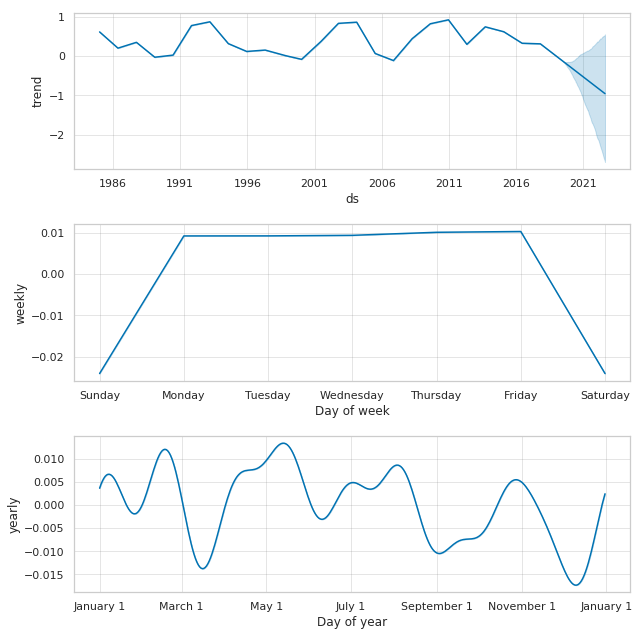

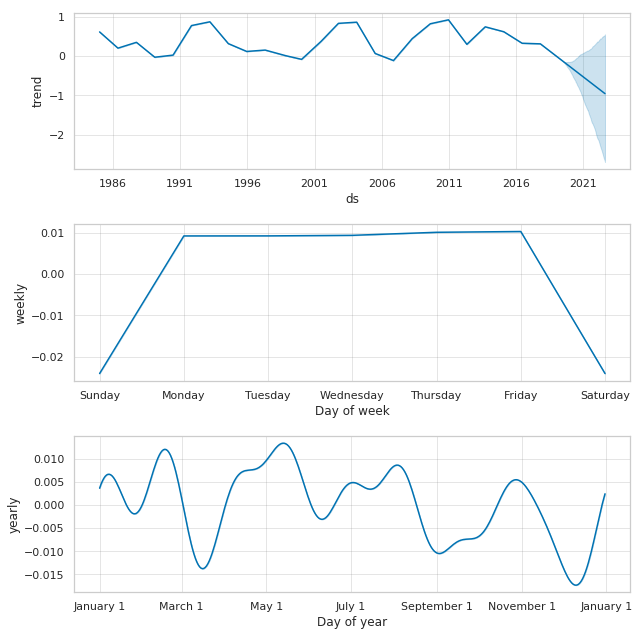

In [24]:
model.plot_components(forecast)

# We can see some interesting trends in the 
# yearly data which we could potentially 
# include to fine tune our model.

## Visualizing the Forecast Uncertainity

In [25]:
cols = ['ds', 'yhat', 'yhat_lower', 'yhat_upper']
forecasting = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].set_index('ds')

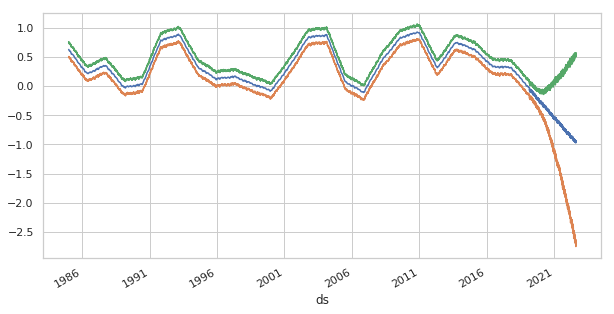

In [26]:
plt.figure(figsize=(10, 5))
plt.plot()

for i in range(1, 4):
#     plt.subplot(2, 1, i)
    forecasting[cols[i]].plot()

# Final Model

We take the interest trend till now and then forecast the trend for the next 3 years.

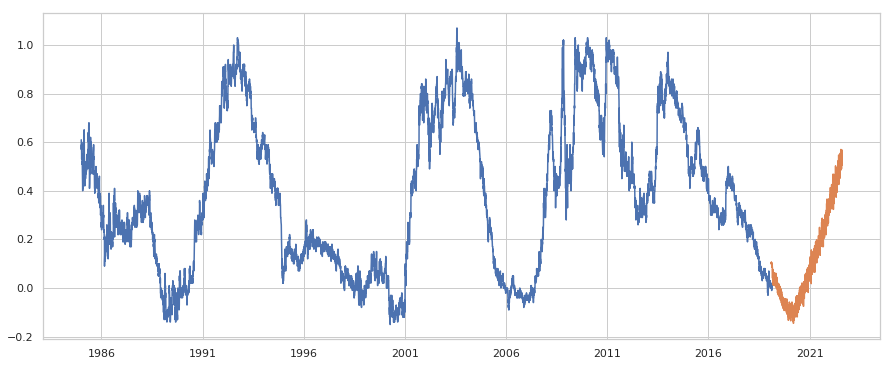

In [27]:
plt.figure(figsize=(15, 6))
plt.plot(df.DIFF)
plt.plot(forecasting['2019-02-08':]['yhat_upper'])

In [28]:
import pickle

with open("yield_curve_model", "wb") as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [29]:
future = model.make_future_dataframe(periods=1260, freq='D')
forecast = model.predict(future)

data = []

forecast_data = forecast[['ds', 'yhat_upper']]
forecast_data['ds'] = pd.to_datetime(forecast_data['ds'])

forecast_data = forecast_data[forecast_data['ds'] > '2019-02-08']

/home/guyandtheworld/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [33]:
forecast_data.to_csv('../data/forecast.csv')

In [34]:
forecast_data.head()

,ds,yhat_upper
8898,2019-02-11,0.101935
8899,2019-02-12,0.102662
8900,2019-02-13,0.101107
8901,2019-02-14,0.112368
8902,2019-02-15,0.104683
